# Table of contents

* [Import Libraries](#Import-Libraries)
* [First Question](#First-Question)
    * [Load in information needed](#Load-in-information-needed)
    * [Checkout the information](#Checkout-the-information)
    * [Answering the first Hypothosis](#Answering-the-first-Hypothosis)
    * [Effect size of discount](#Effect-size-of-discount)
    * [What amount of discount makes the most difference with regards to quantity ordered?](#What-amount-of-discount-makes-the-most-difference-with-regards-to-quantity-ordered?)

## Import Libraries 

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlite3
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from statsmodels.stats.power import TTestIndPower, TTestPower

In [97]:
power_analysis = TTestIndPower()

In [3]:
conn = sqlite3.Connection('Northwind_small.sqlite')
c = conn.cursor()

[Return to contents](#Table-of-contents)

## Northwind Database Map

<img src='Northwind_ERD_updated.png'>

## First Question

Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?  

Null Hypothosis: Discount does not affect quantity of product ordered  
Alternative Hypthosis: Discount does effect the quantity of product ordered  
Alpha: .05  

[Return to contents](#Table-of-contents)

## Load in information needed

In [39]:
c.execute('''Select * from OrderDetail;''')
discountdf = pd.DataFrame(c.fetchall())
discountdf.columns = [x[0] for x in c.description]
discountdf.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


[Return to contents](#Table-of-contents)

## Checkout the information

I want to first see how many items have discounts and how the discount is represented, by dollars or percentage

In [40]:
discountdf.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

It seems to be in percentages and we have 838 items that had a discount on them when ordered

In [41]:
discountdf.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


Checking for Null values

In [42]:
discountdf.isna().sum()

Id           0
OrderId      0
ProductId    0
UnitPrice    0
Quantity     0
Discount     0
dtype: int64

No null values

Checking for placeholder values

In [43]:
discountdf.Quantity.unique()

array([ 12,  10,   5,   9,  40,  35,  15,   6,  20,  25,  42,  21,  30,
        50,  65,   1,  16,   2,  60,  28,  36,  70,   4,  24,  33,   7,
         8,  18,   3,  45, 100,  14,  80,  48,  56,  13,  77,  54,  55,
        32, 120,  49,  90,  39,  84,  11, 110,  27,  44, 130,  52,  91,
        66,  63,  22], dtype=int64)

In [44]:
discountdf.Discount.unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

[Return to contents](#Table-of-contents)

## Answering the Hypothosis

Make a column that has a 1 if there is a discount and a 0 if there is not a discount

In [45]:
discountdf['is_discount'] = 1
discountdf.loc[discountdf.Discount == 0, 'is_discount'] = 0

In [46]:
discountdf.tail()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,is_discount
2150,11077/64,11077,64,33.25,2,0.03,1
2151,11077/66,11077,66,17.00,1,0.00,0
2152,11077/73,11077,73,15.00,2,0.01,1
2153,11077/75,11077,75,7.75,4,0.00,0
2154,11077/77,11077,77,13.00,2,0.00,0


Test Hypothosis One with an Anova table as I am dealing with categorical data

In [47]:
formula1 = 'Quantity ~ C(is_discount)'
lm = ols(formula1, discountdf).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                       sum_sq      df          F        PR(>F)
C(is_discount)   14903.513199     1.0  41.971781  1.144092e-10
Residual        764496.122996  2153.0        NaN           NaN


Very low P-Value so I can reject the Null Hypothosis that discount does not have an affect on quantity ordered

[Return to contents](#Table-of-contents)

## Effect size of discount

To figure out how much of an effect a discount has on the quantity ordered, I will split the information into 2 dataframes, one for discounts and one for no discount

In [53]:
discountdf_discount = discountdf.loc[discountdf.is_discount == 1]
discountdf_discount.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,is_discount
6,10250/51,10250,51,42.4,35,0.15,1
7,10250/65,10250,65,16.8,15,0.15,1
8,10251/22,10251,22,16.8,6,0.05,1
9,10251/57,10251,57,15.6,15,0.05,1
11,10252/20,10252,20,64.8,40,0.05,1


In [54]:
discountdf_no_discount = discountdf.loc[discountdf.is_discount == 0]
discountdf_no_discount.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,is_discount
0,10248/11,10248,11,14.0,12,0.0,0
1,10248/42,10248,42,9.8,10,0.0,0
2,10248/72,10248,72,34.8,5,0.0,0
3,10249/14,10249,14,18.6,9,0.0,0
4,10249/51,10249,51,42.4,40,0.0,0


Let's see what the average quantity ordered is for discount and no discount

In [57]:
discountdf_discount.Quantity.describe()

count    838.000000
mean      27.109785
std       20.771439
min        1.000000
25%       12.000000
50%       20.000000
75%       36.000000
max      130.000000
Name: Quantity, dtype: float64

In [58]:
discountdf_no_discount.Quantity.describe()

count    1317.000000
mean       21.715262
std        17.507493
min         1.000000
25%        10.000000
50%        18.000000
75%        30.000000
max       130.000000
Name: Quantity, dtype: float64

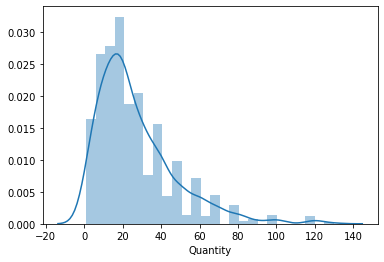

In [64]:
sns.distplot(discountdf_discount.Quantity);

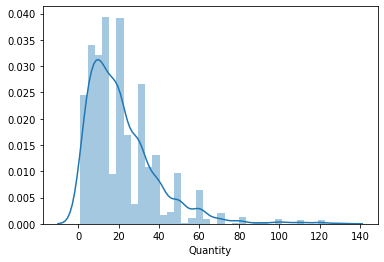

In [65]:
sns.distplot(discountdf_no_discount.Quantity);

It seems we need to cut down on outliers so I will do that now.  
First to see where I should cut them.  
My guess is around 70 for the discount one and probably around the same for no discount

In [81]:
discountdf_discount.Quantity.quantile(.95)

70.0

In [84]:
discountdf_no_discount.Quantity.quantile(.95)

55.0

In [106]:
discountdf_discount = discountdf.loc[(discountdf.is_discount == 1) & (discountdf.Quantity <= 70)]
discountdf_no_discount = discountdf.loc[(discountdf.is_discount == 0) & (discountdf.Quantity <= 55)]

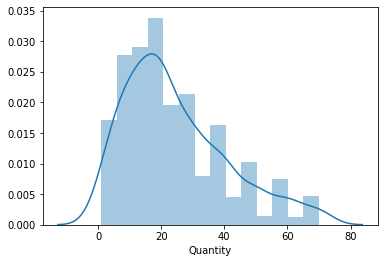

In [86]:
sns.distplot(discountdf_discount.Quantity);

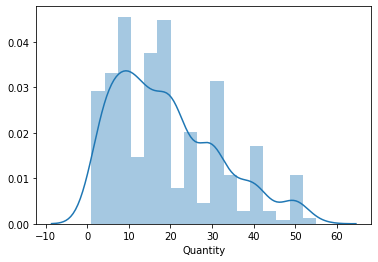

In [87]:
sns.distplot(discountdf_no_discount.Quantity);

In [90]:
discountdf_discount.Quantity.describe()

count    809.000000
mean      24.716934
std       16.485674
min        1.000000
25%       12.000000
50%       20.000000
75%       35.000000
max       70.000000
Name: Quantity, dtype: float64

In [94]:
discountdf_no_discount.Quantity.describe()

count    1252.000000
mean       19.031150
std        12.550769
min         1.000000
25%        10.000000
50%        16.000000
75%        28.000000
max        55.000000
Name: Quantity, dtype: float64

In [95]:
effect_size = discountdf_discount.Quantity.mean() - discountdf_no_discount.Quantity.mean()
effect_size

5.685784327276604

[Return to contents](#Table-of-contents)

### What amount of discount makes the most difference with regards to quantity ordered?

In [113]:
discount_dummies = pd.get_dummies(discountdf_discount.Discount, prefix='Dis')

In [116]:
discountdf_discount = pd.concat([discountdf_discount, discount_dummies], axis=1)
discountdf_discount.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,is_discount,Dis_0.01,Dis_0.02,Dis_0.03,Dis_0.04,Dis_0.05,Dis_0.06,Dis_0.1,Dis_0.15,Dis_0.2,Dis_0.25
6,10250/51,10250,51,42.4,35,0.15,1,0,0,0,0,0,0,0,1,0,0
7,10250/65,10250,65,16.8,15,0.15,1,0,0,0,0,0,0,0,1,0,0
8,10251/22,10251,22,16.8,6,0.05,1,0,0,0,0,1,0,0,0,0,0
9,10251/57,10251,57,15.6,15,0.05,1,0,0,0,0,1,0,0,0,0,0
11,10252/20,10252,20,64.8,40,0.05,1,0,0,0,0,1,0,0,0,0,0


In [130]:
discountdf_discount.rename(columns={'Dis_0.01': 'Dis_01', 'Dis_0.02': 'Dis_02', 'Dis_0.03': 'Dis_03', 'Dis_0.04': 'Dis_04', 'Dis_0.05': 'Dis_05', 'Dis_0.06': 'Dis_06', 'Dis_0.1': 'Dis_1', 'Dis_0.15': 'Dis_15', 'Dis_0.2': 'Dis_2', 'Dis_0.25': 'Dis_25'}, inplace=True)

In [131]:
discountdf_discount.columns

Index(['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount',
       'is_discount', 'Dis_01', 'Dis_02', 'Dis_03', 'Dis_04', 'Dis_05',
       'Dis_06', 'Dis_1', 'Dis_15', 'Dis_2', 'Dis_25'],
      dtype='object')

See how many of each category we have

In [134]:
discountdf_discount.sum()

Id             10250/5110250/6510251/2210251/5710252/2010252/...
OrderId                                                  8618230
ProductId                                                  32066
UnitPrice                                                21389.1
Quantity                                                   19996
Discount                                                  117.19
is_discount                                                  809
Dis_01                                                         1
Dis_02                                                         2
Dis_03                                                         3
Dis_04                                                         1
Dis_05                                                       177
Dis_06                                                         1
Dis_1                                                        167
Dis_15                                                       150
Dis_2                    

In [136]:
discountdf_discount['Dis_1_to_6'] = 0
discountdf_discount.loc[(discountdf_discount.Dis_01 == 1) | (discountdf_discount.Dis_02 == 1) | (discountdf_discount.Dis_03 == 1) | (discountdf_discount.Dis_04 == 1) | (discountdf_discount.Dis_05 == 1) | (discountdf_discount.Dis_06 == 1), 'Dis_1_to_6'] = 1 

In [138]:
discountdf_discount.tail()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,is_discount,Dis_01,Dis_02,Dis_03,Dis_04,Dis_05,Dis_06,Dis_1,Dis_15,Dis_2,Dis_25,Dis_1_to_6
2144,11077/39,11077,39,18.00,2,0.05,1,0,0,0,0,1,0,0,0,0,0,1
2146,11077/46,11077,46,12.00,3,0.02,1,0,1,0,0,0,0,0,0,0,0,1
2149,11077/60,11077,60,34.00,2,0.06,1,0,0,0,0,0,1,0,0,0,0,1
2150,11077/64,11077,64,33.25,2,0.03,1,0,0,1,0,0,0,0,0,0,0,1
2152,11077/73,11077,73,15.00,2,0.01,1,1,0,0,0,0,0,0,0,0,0,1


As all the lower discounts only have 1-3 of each I grouped them into one category

In [139]:
formula1a = 'Quantity ~ C(Dis_1_to_6) + C(Dis_1) + C(Dis_15) + C(Dis_2) + C(Dis_25)'
lm = ols(formula1a, discountdf_discount).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                      sum_sq     df          F    PR(>F)
C(Dis_1_to_6)    2571.647211    1.0   9.479863  0.002148
C(Dis_1)          704.681547    1.0   2.597668  0.107414
C(Dis_15)        4574.067310    1.0  16.861384  0.000044
C(Dis_2)         4555.651958    1.0  16.793500  0.000046
C(Dis_25)        6051.074474    1.0  22.306076  0.000003
Residual       218104.875547  804.0        NaN       NaN


We can reject the null hypothosis only with discounts of .05, .15, .2 and .25 while with a 10% discount we can not reject the null hypothosis that it is not better then not having a discount

[Return to contents](#Table-of-contents)

## Conclusion

In [ ]:
We can recommend using 

In [27]:
c.execute('''select name from sqlite_master where type = 'table';''')
c.fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]